## Part B: Analysing South Australia Crime Data (CSV)

#### Developer: Anh Van
#### Email: ngockhueanhvan@gmail.com
Date: 10/08/2019
Version: 1.0
Environment: Python 3.5 and Jupyter Notebook

#### Libraries used:
- pypark
- matplotlib

#### Introduction:
- We are going to analyse crime data from South Australia.
- The dataset reflects reported incidents of crime (suburb-based crime statistics for crimes against the person and crimes against property)
- The records are incidents that occurred in South Australia since 2010

### Step 1: Import Pyspark and initialize Spark 
This step involves:
- Writing the code to create SparkContext object, which tells Spark how to access a  cluster.
- We first need to build a SparkConf object that contains information about out application
- Give a name for our application and run Spark locally with as many working processors as logical cores on out machine
- Write the code to create a SparkSession obect that can be use to create the dataframe from the input data source (CSV file)

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.mongodb.spark:mongo-spark-connector_2.11:2.4.0 pyspark-shell'

# create entry points to spark
from pyspark import SparkConf, SparkContext # Spark
from pyspark.sql import SparkSession # Spark SQL

# If there is an existing spark context, we will reuse it instead of creating a new context.
sc = SparkContext.getOrCreate()

# local[*]: run Spark locally with as many working processors as logical cores on your machine.
# In the field of `master`, we use a local server with as many working processors (or threads) as possible (i.e. `local[*]`). 
# The `appName` field is a name to be shown on the Sparking cluster UI. 

# If there is no existing spark context, we now create a new context
if (sc is None):
    sc = SparkContext(master="local[*]")
my_spark = SparkSession(sparkContext=sc)\
    .builder \
    .appName("Assignment1_PartB") \
    .config("spark.mongodb.input.uri", "mongodb://127.0.0.1/ass1.partb") \
    .config("spark.mongodb.output.uri", "mongodb://127.0.0.1/ass1.partb") \
    .getOrCreate()

### Step 2: Create dataframe
This task involves
- Write the code to create a dataframe and provide the data source as the CSV file
- Calculate how many lines in the data frame

In [2]:
# read the data from a CSV file and create a dataframe
df = my_spark.read.csv("Crime_Statistics_SA_2010_present.csv", header=True)

In [3]:
# count the number of lines and print out
print("The total number of records in the dataframe is {0}".format(df.count()))

The total number of records in the dataframe is 727408


### Step 3: Write to database
This tasks involves
- Read the CSV file using Spark Session
- Insert all the records into MongoDB
- Use 'overwrite' mode for inserting

In [4]:
# insert the dataframe created in Step 2 into MongoBD
df.write.format('com.mongodb.spark.sql.DefaultSource').option('database', 'ass1').option('collection', 'partb').mode('overwrite').save()

In [5]:
# show the top 20 lines
df.show(truncate=False)

+-------------+-----------------+-------------------+---------------------------+------------------------------------+---------------------------------------+-------------+
|Reported Date|Suburb - Incident|Postcode - Incident|Offence Level 1 Description|Offence Level 2 Description         |Offence Level 3 Description            |Offence Count|
+-------------+-----------------+-------------------+---------------------------+------------------------------------+---------------------------------------+-------------+
|1/07/2010    |ADELAIDE         |5000               |OFFENCES AGAINST PROPERTY  |FRAUD DECEPTION AND RELATED OFFENCES|Obtain benefit by deception            |2            |
|1/07/2010    |ADELAIDE         |5000               |OFFENCES AGAINST PROPERTY  |PROPERTY DAMAGE AND ENVIRONMENTAL   |Other property damage and environmental|2            |
|1/07/2010    |ADELAIDE         |5000               |OFFENCES AGAINST PROPERTY  |SERIOUS CRIMINAL TRESPASS           |SCT - Non Residen

### Step 4: Read from dataframe
This task involves
- Create a Spark Dataframe to hold data from the MongoDB collection
- Display the schema of the dataframe

In [6]:
# create a Spark Dataframe to hold data from the MongoDB collection
new_df = my_spark.read.format('com.mongodb.spark.sql.DefaultSource').option("uri","mongodb://127.0.0.1/ass1.partb").load()

In [7]:
# display the schema of the dataframe
new_df.printSchema()

root
 |-- Offence Count: string (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: string (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



### Step 5: Calculate the statistics of numeric and string columns
This task involves
- Calculate the statistics of "Offence Count" and "Reported Date".
- Find the count, mean, standard deviation, minimum and maximum for these attributes.
- Explain with reasoning whether the minimum and maximum reported date is correct

In [8]:
# find the count, mean, standard deviation, minimum and maximum for "Offence Count" and "Reported Date"
new_df.select("Offence Count", "Reported Date").describe().show()

+-------+------------------+-------------+
|summary|     Offence Count|Reported Date|
+-------+------------------+-------------+
|  count|            727407|       727407|
|   mean|1.1715174585892079|         null|
| stddev| 0.578705093037813|         null|
|    min|                 1|    1/01/2011|
|    max|                 9|    9/12/2018|
+-------+------------------+-------------+



> - As we can see the Schema in Step 4, both "Offence Count" and "Reported Date" are in string format whereas they should be interger and date, respectively
- Due to the incorrect data type of both attributes, the calculated statistics must have been incorrect as well
- In fact, because the current datatype is string, pyspark would calculate the statistics alphabetically rather than numerically
- Regarding "Reported Date", the minimum date is 1/1/2011 whereas from the specs we already know that the crime records are since 2010. Furthermore, we can see some of records in 2010 from the show() function ofo step 2. Thus, we can confirm that the statictics here is wrong. Similarly, maximum date should have been wrong as well

### Step 6: Change the data type of a column
This task involves
- The date column is in string format, we are going to change it to date format using uder-defined functions (udf)

In [9]:
from datetime import datetime
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DateType
# setting an user define function:
# this function converts the string cell into a date:
func =  udf (lambda x: datetime.strptime(x, '%d/%m/%Y'), DateType())

# apply the function to dataframe
main_df = new_df.withColumn('Reported Date',func('Reported Date'))

In [10]:
from pyspark.sql.types import IntegerType

# also, we would wish to change the format of "Offence Count" to interger
main_df = main_df.withColumn("Offence Count", main_df["Offence Count"].cast(IntegerType()))

In [11]:
# let's print again the schema
main_df.printSchema()

root
 |-- Offence Count: integer (nullable = true)
 |-- Offence Level 1 Description: string (nullable = true)
 |-- Offence Level 2 Description: string (nullable = true)
 |-- Offence Level 3 Description: string (nullable = true)
 |-- Postcode - Incident: string (nullable = true)
 |-- Reported Date: date (nullable = true)
 |-- Suburb - Incident: string (nullable = true)
 |-- _id: struct (nullable = true)
 |    |-- oid: string (nullable = true)



In [12]:
# now, we recheck by calculate the descriptive statistics again
main_df.select("Offence Count", "Reported Date").describe().show()

+-------+------------------+
|summary|     Offence Count|
+-------+------------------+
|  count|            727407|
|   mean|1.1715174585892079|
| stddev|0.5787050930378078|
|    min|                 1|
|    max|                28|
+-------+------------------+



### Step 7: Preliminary data analysis
Write the code to answer the following analytical queries.
- How many level 2 offences are there? Display the list of level 2 offences.
- What is the number of offences against the person?
- How many serious criminal tresspasses with more than 1 offence count?
- What percentage of crimes are offences against the property?

#### 7.1 How many level 2 offences are there? Display the list of level 2 offences.

In [13]:
from pyspark.sql.functions import countDistinct
from pyspark.sql import functions as func

In [14]:
# first, we calculate the number of distinct values of Offence Level 2
total_lv2 = main_df.groupby().agg(countDistinct('Offence Level 2 Description')).collect()[0][0]
print("There are {0} unique types of Offence level 2\n".format(total_lv2))

# in each Offence Level 1, we are going to  find how many types of Offence Level 2

# offence against the person
lv2_person = main_df.where(col('Offence Level 1 Description')=='OFFENCES AGAINST THE PERSON')\
.agg(countDistinct('Offence Level 2 Description')).collect()[0][0]
print("Offences against the person:\n- There are {0} unique types of Offence level 2\n".format(lv2_person))

# offence against property
lv2_property = main_df.where(col('Offence Level 1 Description')=='OFFENCES AGAINST PROPERTY')\
.agg(countDistinct('Offence Level 2 Description')).collect()[0][0]
print("Offences against property:\n- There are {0} unique types of Offence level 2\n".format(lv2_property))


There are 9 unique types of Offence level 2

Offences against the person:
- There are 5 unique types of Offence level 2

Offences against property:
- There are 4 unique types of Offence level 2



In [15]:
# next, we list out all the types of Offence Level 2 in each Offence Level 1 
list = main_df.select('Offence Level 1 Description','Offence Level 2 Description').orderBy('Offence Level 1 Description', ascending =False).distinct()
# list.show(truncate=False)

In [16]:
# ofence against the person
print("{0} includes: \n- {1}\n- {2}\n- {3}\n- {4}\n- {5}\n".format(list.collect()[1][0],\
                                                                 list.collect()[0][1],\
                                                                 list.collect()[1][1],\
                                                                 list.collect()[2][1],\
                                                                 list.collect()[3][1],\
                                                                 list.collect()[4][1]))

# offence against property
print("{0} includes: \n- {1}\n- {2}\n- {3}\n- {4}".format(list.collect()[6][0],\
                                                          list.collect()[5][1],\
                                                          list.collect()[6][1],\
                                                          list.collect()[7][1],\
                                                          list.collect()[8][1]))

OFFENCES AGAINST THE PERSON includes: 
- OTHER OFFENCES AGAINST THE PERSON
- ACTS INTENDED TO CAUSE INJURY
- SEXUAL ASSAULT AND RELATED OFFENCES
- ROBBERY AND RELATED OFFENCES
- HOMICIDE AND RELATED OFFENCES

OFFENCES AGAINST PROPERTY includes: 
- PROPERTY DAMAGE AND ENVIRONMENTAL
- THEFT AND RELATED OFFENCES
- SERIOUS CRIMINAL TRESPASS
- FRAUD DECEPTION AND RELATED OFFENCES


#### 7.2 What is the number of offences against the person?

In [17]:
# calculate the number of offences against the person accross all cases
person_offence = main_df.where(col('Offence Level 1 Description')=='OFFENCES AGAINST THE PERSON')\
.agg(func.sum('Offence Count')).collect()[0][0]

# print out statment
print("There are a total of {0} offences against the person".format(person_offence))

There are a total of 175644 offences against the person


#### 7.3 How many serious criminal tresspasses with more than 1 offence count
- In this question, we are going to count for each suburb in a specific date, how many records about serious criminal tresspasses with  more than 1 offence occurred

In [18]:
from pyspark.sql.functions import count, col, when, lit

In [19]:
# filter the Offence Level 2 to be "serious criminal trespass"
serious = main_df.where(col('Offence Level 2 Description')=='SERIOUS CRIMINAL TRESPASS')

# from the list, count how many records with more than 1 offence occurred
serious = serious.agg(count(when(col('Offence Count')>1, True)))

# print
print("The total number of serious criminal trespasses with more than 1 offence count is {0}".format(serious.collect()[0][0]))

The total number of serious criminal trespasses with more than 1 offence count is 8579


#### 7.4 What percentage of crimes are offences against the property

In [20]:
# the total number of offence against property
property_offence = main_df.where(col('Offence Level 1 Description')=='OFFENCES AGAINST PROPERTY')\
.agg(func.sum('Offence Count')).collect()[0][0]

# the total number of offences
total_offence = main_df.agg(func.sum('Offence Count')).collect()[0][0]

# percentage of crimes are offences against the property
per_property = (property_offence/total_offence)*100

print("Amongst all offences, {0}% are offences against property".format(round(per_property,2)))

Amongst all offences, 79.39% are offences against property


### Step 8: Exploratory data analysis
This task involves
- Write code to analyse the analytical queries
    - Find the number of crime per year
    - Find the number of crime per month
    - Where do most crimes take place? Find the top 20 suburbs
    - Find the number of serious trespasses by day and by month
- Visualise using the standard matplotlib library

In [21]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [22]:
import datetime
from pyspark.sql.functions import year, month, date_format

In [24]:
# we are going to extract year, month and weekday from date column and add new columns to the dataframe
adjust_df = main_df.withColumn("Year", year("Reported Date"))\
.withColumn("Month", month("Reported Date"))\
.withColumn("Weekday", date_format('Reported Date', 'E'))\
.where(col('Offence Count').isNotNull()) # exclude the null values of 'Offence Count'

#### 8.1 The number of crime per year

In [25]:
# compute the number of crimes occurred by year
yearly_offence = adjust_df.groupby('Year')\
.agg(func.sum("Offence Count").alias("Total Offence"))\
.sort('Year')\
.collect()

>- Let's first explore the data to see how many months we have for each year for better comparison of the yearly data
- We can see from below, from 2011-2016 we have full data for each year. However, we only have half year data for 2010, 2017 and 2018. In 2019, we only have data of the first 3 months

In [26]:
adjust_df.groupby('Year')\
.agg(countDistinct('Month'))\
.withColumnRenamed('count(DISTINCT Month)','Total number of months')\
.sort('Year').show()

+----+----------------------+
|Year|Total number of months|
+----+----------------------+
|2010|                     6|
|2011|                    12|
|2012|                    12|
|2013|                    12|
|2014|                    12|
|2015|                    12|
|2016|                    12|
|2017|                     6|
|2018|                     6|
|2019|                     3|
+----+----------------------+



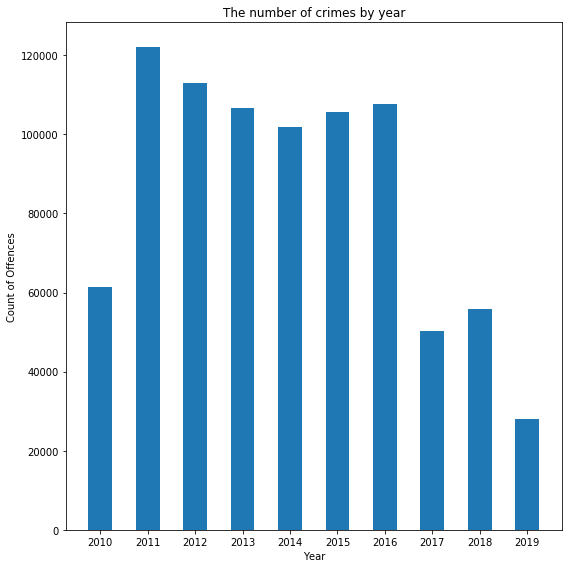

In [27]:
# prepare data
offences = [row['Total Offence'] for row in yearly_offence]
years = [row['Year'] for row in yearly_offence]

# plot
bar_width = 0.5
y_pos = np.arange(len(years))
plt.figure(figsize=(8,8))

plt.bar(y_pos, offences, bar_width, align='center', color='C0')
plt.xticks(y_pos, years)
plt.xlabel('Year')
plt.ylabel('Count of Offences')
plt.title('The number of crimes by year')
plt.tight_layout()
plt.show()


> - Noted that from 2011-2016 we have full data for each year. However, we only have half year data for 2010, 2017 and 2018. In 2019, we only have data of the first 3 months
- From 2011 to 2014, there is a steadily downwarding trend of yearly number of offences. However, the crime numbers picked up again in 2017 and 2018.
- Since in 2017 and 2018, we only have half year data, we can compare these two years. In particular, crime rate slightly increased in 2018 compared with 2017

#### 8.2 The number of crime per month

In [28]:
# compute the total crimes by month
monthly_offence = adjust_df.groupby('Month')\
.agg(func.sum("Offence Count").alias("Total Offence"))\
.sort('Month')\
.collect()

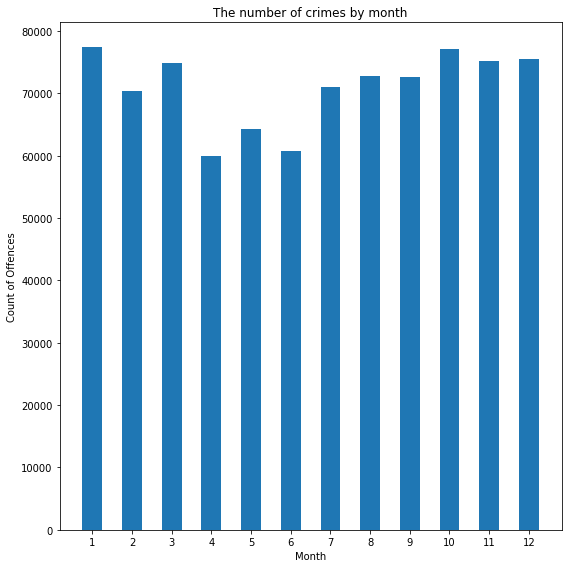

In [29]:
# prepare data
offences = [row['Total Offence'] for row in monthly_offence]
months = [row['Month'] for row in monthly_offence]

# plot
bar_width = 0.5
y_pos = np.arange(len(months))
plt.figure(figsize=(8,8))

plt.bar(y_pos, offences, bar_width, align='center', color='C0')
plt.xticks(y_pos, months)
plt.xlabel('Month')
plt.ylabel('Count of Offences')
plt.title('The number of crimes by month')
plt.tight_layout()
plt.show()

> - Disregard the limitation of data (some months don't have data) 
- The number of offences occured fluctuated during a year
- The autumn time from April to June had the lowest crime rate
- The crime rate was quite stable during year-end months (the latter half of the year)

#### 8.3 The top 20 suburbs where most crimes take place

In [30]:
# get rid the of null values
suburb_df = adjust_df.where(col('Suburb - Incident').isNotNull())\
.where(col('Postcode - Incident').isNotNull())

# concat the Suburb and postcode to create a new column 'Suburb_Code'
suburb_df = suburb_df.withColumn('Suburb_Code', func.concat(func.col('Suburb - Incident'), 
                                                            func.lit("_"), 
                                                            func.col('Postcode - Incident')))

In [32]:
# calculate the offences by suburb
suburb_offence = suburb_df.groupby('Suburb_Code')\
.agg(func.sum("Offence Count").alias("Total Offence"))\
.sort('Total Offence', ascending = 0)

# list of top 20 suburbs
top_20 = suburb_offence.take(20)

In [33]:
# suburb_offence.show()

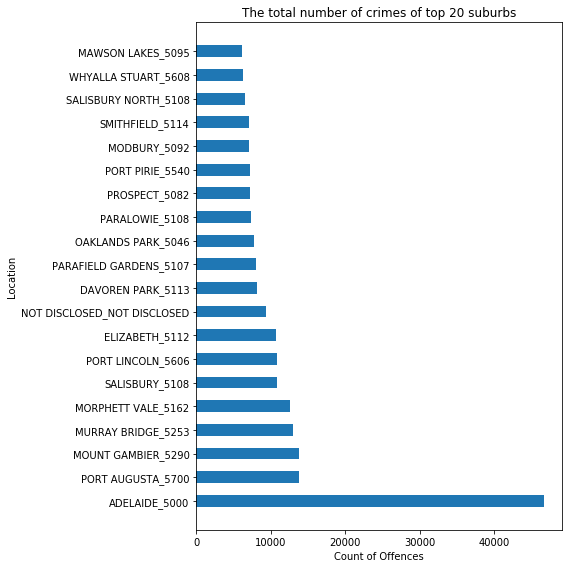

In [34]:
# prepare data
offences = [row['Total Offence'] for row in top_20]
location = [row['Suburb_Code'] for row in top_20]

# plot
bar_width = 0.5
y_pos = np.arange(len(location))
plt.figure(figsize=(8,8))

plt.barh(y_pos, offences, bar_width, align='center', color='C0')
plt.yticks(y_pos, location)
plt.xlabel('Count of Offences')
plt.ylabel('Location')
plt.title('The total number of crimes of top 20 suburbs')
plt.tight_layout()
plt.show()

> - In Adelaid, the number of offences is the highest and moreover, significantly higher compared to other suburbs
- According to the figures, Adelaid's figure is more than triple of the second highest suburb
- There is no much difference between the other 19 suburbs, fluctuating around 10,000 offences throughout the period

#### 8.4 The number of serious trespasses by day and by month

In [35]:
# the number of serious trespasses by day and by month
serious_offence = adjust_df.where(col('Offence Level 2 Description')=='SERIOUS CRIMINAL TRESPASS')\
.groupby('Weekday','Month')\
.agg(func.sum("Offence Count").alias("Total Offence"))\
.sort("Weekday","Month")

In [36]:
# extract data by weekday
mon = serious_offence.where(col('Weekday')=='Mon').collect() # monday
tue = serious_offence.where(col('Weekday')=='Tue').collect() # tuesday
wed = serious_offence.where(col('Weekday')=='Wed').collect() # wednesday
thu = serious_offence.where(col('Weekday')=='Thu').collect() # thursday
fri = serious_offence.where(col('Weekday')=='Fri').collect() # friday
sat = serious_offence.where(col('Weekday')=='Sat').collect() # saturday
sun = serious_offence.where(col('Weekday')=='Sun').collect() # sunday

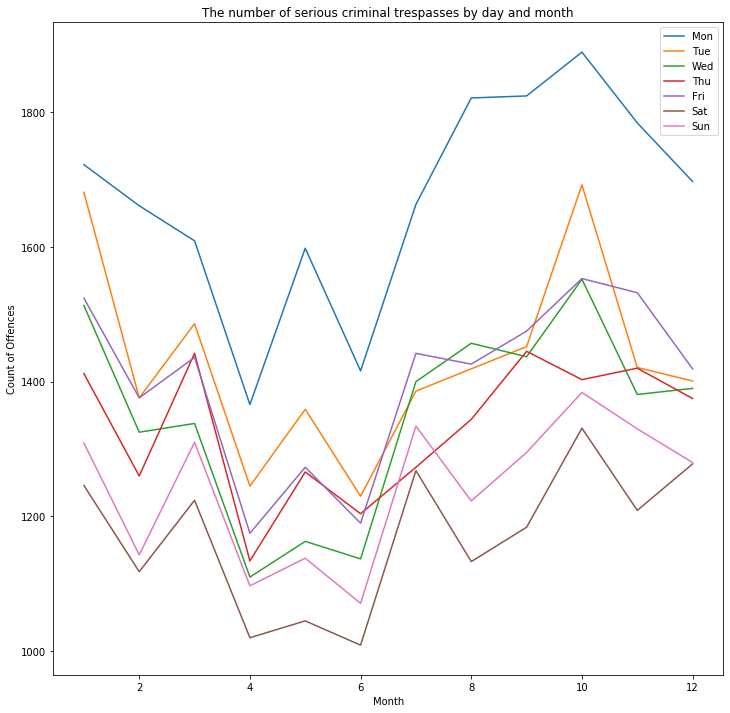

In [37]:
# plot the chart
month = [row['Total Offence'] for row in mon]
labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

plt.figure(figsize=(12,12))
plt.xlabel('Month')
plt.ylabel('Count of Offences')
plt.title('The number of serious criminal trespasses by day and month')

# plot one line for each weekday accross 12 months
plt.plot([row['Month'] for row in mon], [row['Total Offence'] for row in mon]) # mon
plt.plot([row['Month'] for row in mon], [row['Total Offence'] for row in tue]) # tue
plt.plot([row['Month'] for row in mon], [row['Total Offence'] for row in wed]) # wed
plt.plot([row['Month'] for row in mon], [row['Total Offence'] for row in thu]) # thu
plt.plot([row['Month'] for row in mon], [row['Total Offence'] for row in fri]) # fri
plt.plot([row['Month'] for row in mon], [row['Total Offence'] for row in sat]) # sat
plt.plot([row['Month'] for row in mon], [row['Total Offence'] for row in sun]) # sun

plt.legend(labels, loc=1)
plt.show()

> - In overall, crime rates were highest for the beginning of the week (Monday, Tuesday, Wednesday) and lowest for the week-ends
- The monthly patterns are quite similar accross different weekdays. In particular, crime rate started to drop in April and kept low during April-June, then started to climb back and reached the peak at October. Afterwards, the crime rates decreased towards year-end
- Monday should be in blacklist with careful consideration because Monday has consistently higher crime rates compared with other weekdays
